In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
import tensorflow as tf
import albumentations as A
import imgaug.augmenters as iaa
from imgaug import parameters as iap
import warnings
warnings.filterwarnings('ignore')

# **Showing the original Image**

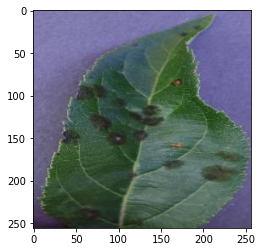

In [ ]:
image = cv2.imread('/content/leaf_image.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
# augmentations
albumentation_list = [A.RandomSunFlare(p=1), 
                      A.RandomFog(p=1), 
                      A.RandomBrightness(p=1),
                      A.RandomCrop(p=1, height = 250, width = 250), 
                      A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), 
                      A.RandomSnow(p=1),
                      A.HorizontalFlip(p=1), 
                      A.VerticalFlip(p=1), 
                      A.RandomContrast(limit = 0.5,p = 1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),
                      A.Cutout(p=1),
                      A.Transpose(p=1), 
                      A.JpegCompression(p=1),
                      A.CoarseDropout(p=1),
                      A.IAAAdditiveGaussianNoise(loc=0, scale=(2.5500000000000003, 12.75), per_channel=False, p=1),
                      A.IAAAffine(scale=1.0, translate_percent=None, 
                                  translate_px=None, rotate=0.0, shear=0.0, 
                                  order=1, cval=0, mode='reflect', p=1),
                      A.IAAAffine(rotate=90., p=1),
                      A.IAAAffine(rotate=180., p=1)]

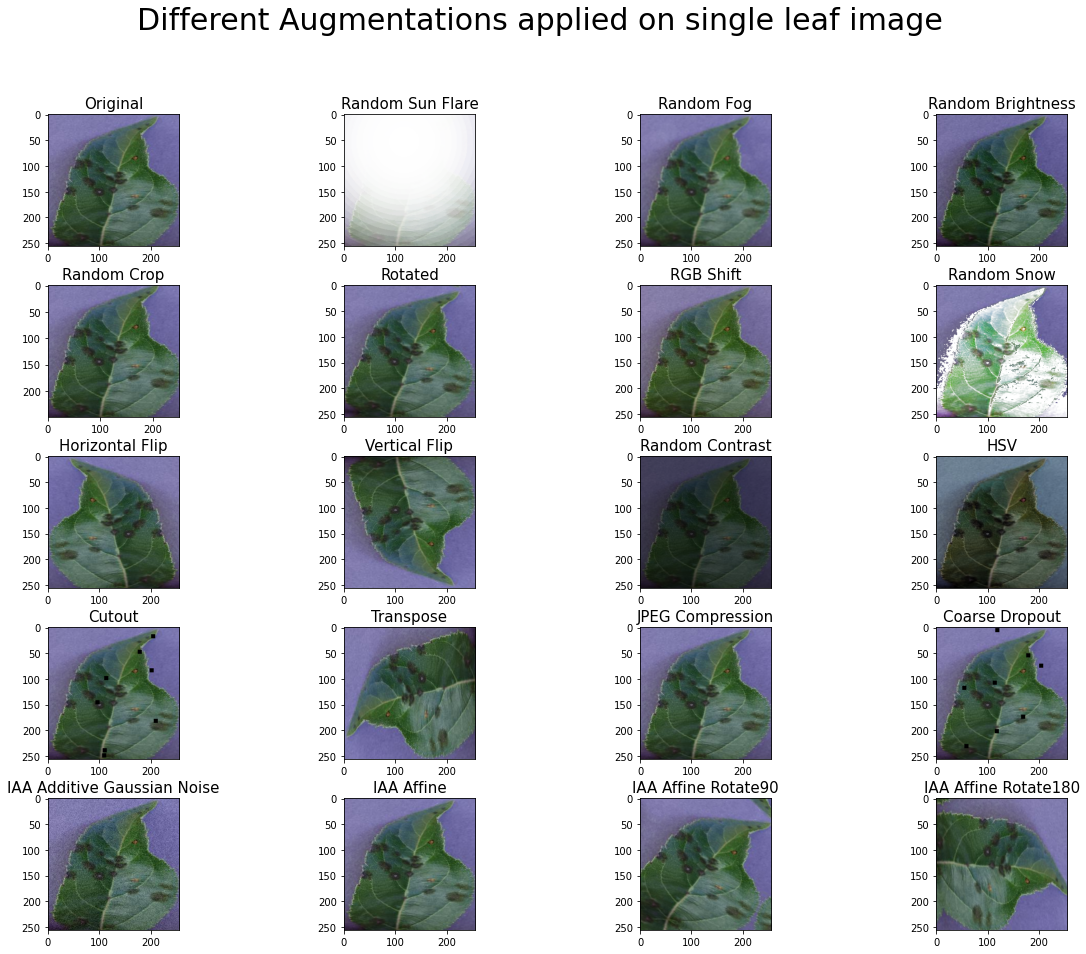

In [ ]:
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0, image)    

titles_list = ["Original","Random Sun Flare","Random Fog","Random Brightness",
               "Random Crop","Rotated", "RGB Shift", "Random Snow","Horizontal Flip", "Vertical Flip", "Random Contrast","HSV",
               "Cutout","Transpose","JPEG Compression","Coarse Dropout","IAA Additive Gaussian Noise","IAA Affine","IAA Affine Rotate90","IAA Affine Rotate180"]

def plot_multiple_img(img_matrix_list, title_list, ncols, nrows=5,  main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()
    
plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title="Different Augmentations applied on single leaf image")

# **Augmented Dataset Creation**

In [ ]:
!wget 'https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/nnytj2v3n5-1.zip'

--2023-04-20 12:05:08--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/nnytj2v3n5-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 3.5.65.1, 52.92.2.170, 52.92.20.178, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|3.5.65.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 423988543 (404M) [application/zip]
Saving to: ‘nnytj2v3n5-1.zip’

nnytj2v3n5-1.zip    100%[===================>] 404.35M  29.0MB/s    in 15s     

2023-04-20 12:05:24 (26.8 MB/s) - ‘nnytj2v3n5-1.zip’ saved [423988543/423988543]



In [ ]:
!unzip '/content/nnytj2v3n5-1.zip'

In [ ]:
# creating copies of the dataset
import shutil

shutil.copytree('/content/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/', 'nature_based_augmentation/')
shutil.copytree('/content/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/', 'flip_based_augmentation/')
shutil.copytree('/content/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/', 'noise_based_augmentation/')
shutil.copytree('/content/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/', 'contrast_based_augmentation/')

'contrast_based_augmentation/'

In [ ]:
# augmentations
albumentation_list1 = [A.RandomSunFlare(p=1)]
albumentation_list2 = [A.Rotate(p=1, limit=90)]   
albumentation_list3 = [A.IAAAdditiveGaussianNoise(loc=0, scale=(2.5500000000000003, 12.75), per_channel=False, p=1),]
albumentation_list4 = [A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50),]

In [ ]:
from math import ceil
import os

def split_data(files, augmentation_list):
  n = len(augmentation_list)

  size = ceil(len(files) / n)
  return list(
    map(lambda x: files[x * size:x * size + size],
    list(range(n)))
  )

def augment_data(dir_path, augmentation_list):
  files = os.listdir(dir_path)
  split_sets = split_data(files, augmentation_list)

  set_complete = 0

  for images in split_sets:
    for image in images:
      image_path = dir_path + '/' + image
      image_obj = cv2.imread(image_path)
      for aug in augmentation_list:
        img = aug(image = image_obj)['image']
        pil_image = Image.fromarray(img)
        pil_image.save(image_path)

    set_complete += 1

  return set_complete

In [ ]:
# applying nature based augmentation
def augment_whole_dataset(path, aug_type):
  type_folder = os.listdir(path)
  print("Total Herb Types: ", len(type_folder))

  total_sets = 0
  for herb_type in tqdm(type_folder):
    image_folder = os.path.join(path, herb_type)
    total_sets += augment_data(image_folder, aug_type)

  return total_sets

In [ ]:
path = '/content/nature_based_augmentation'
augment_whole_dataset(path, albumentation_list1)

Total Herb Types:  30


100%|██████████| 30/30 [05:46<00:00, 11.55s/it]


30

In [ ]:
path = '/content/flip_based_augmentation'
augment_whole_dataset(path, albumentation_list2)

Total Herb Types:  30


100%|██████████| 30/30 [03:20<00:00,  6.69s/it]


30

In [ ]:
path = '/content/noise_based_augmentation'
augment_whole_dataset(path, albumentation_list3)

Total Herb Types:  30


100%|██████████| 30/30 [05:11<00:00, 10.37s/it]


30

In [ ]:
path = '/content/contrast_based_augmentation'
augment_whole_dataset(path, albumentation_list4)

Total Herb Types:  30


100%|██████████| 30/30 [03:13<00:00,  6.44s/it]


30

In [ ]:
!rm -r '/content/drive/MyDrive/IP_Data'

In [ ]:
# shutil.copytree('/content/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images/', '/content/drive/MyDrive/IP_DATA/Segmented Medicinal Leaf Images/')
shutil.copytree('/content/contrast_based_augmentation/', '/content/drive/MyDrive/IP_DATA/contrast_based_augmentation/')
# shutil.copytree('/content/flip_based_augmentation/', '/content/drive/MyDrive/IP_DATA/flip_based_augmentation/')
# shutil.copytree('/content/nature_based_augmentation/', '/content/drive/MyDrive/IP_DATA/nature_based_augmentation/')
# shutil.copytree('/content/noise_based_augmentation', '/content/drive/MyDrive/IP_DATA/noise_based_augmentation/')

'/content/drive/MyDrive/IP_DATA/contrast_based_augmentation/'

In [ ]:
shutil.copytree('/content/Medicinal Leaf Dataset/Segmented Medicinal Leaf Images', '/content/final_dataset', dirs_exist_ok=True)

'/content/final_dataset'

In [ ]:
def rename_files(DIRNAME, types):
  type_folder = os.listdir(DIRNAME)
  print("Total Herb Types: ", len(type_folder))

  total_sets = 0
  for herb_type in tqdm(type_folder):
    image_folder = os.path.join(DIRNAME, herb_type)
    images = os.listdir(image_folder)

    for image in images:
      new_name = types + "_" + image[-12:]
      old_pth = os.path.join(image_folder, image)
      new_pth = os.path.join(image_folder, new_name)

      os.rename(old_pth, new_pth)

  return 'Done'

In [ ]:
rename_files('/content/contrast_based_augmentation', 'contrast')

Total Herb Types:  30


100%|██████████| 30/30 [00:00<00:00, 374.42it/s]


'Done'

In [ ]:
rename_files('/content/flip_based_augmentation', 'flip')
rename_files('/content/nature_based_augmentation', 'nature')
rename_files('/content/noise_based_augmentation', 'noise')

Total Herb Types:  30


100%|██████████| 30/30 [00:00<00:00, 514.08it/s]


Total Herb Types:  30


100%|██████████| 30/30 [00:00<00:00, 527.50it/s]


Total Herb Types:  30


100%|██████████| 30/30 [00:00<00:00, 555.70it/s]


'Done'

In [ ]:
shutil.copytree('/content/contrast_based_augmentation', '/content/final_dataset', dirs_exist_ok=True)

'/content/final_dataset'

In [ ]:
shutil.copytree('/content/flip_based_augmentation', '/content/final_dataset', dirs_exist_ok=True)

'/content/final_dataset'

In [ ]:
shutil.copytree('/content/nature_based_augmentation', '/content/final_dataset', dirs_exist_ok=True)
shutil.copytree('/content/noise_based_augmentation', '/content/final_dataset', dirs_exist_ok=True)

'/content/final_dataset'

In [ ]:
!zip -r '/content/final_dataset.zip' '/content/final_dataset'